In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import visualization
from visualization import *

import cnn
from cnn import *

In [189]:
#wav_to_spectrogram("data/raw/baroque/Bach, JS_ Brandenburg Concerto No. 2 in F Major, BWV 1047_ I. — _ Johann Sebastian Bach, Mark Bennet.wav", "data/spectrograms")

In [190]:
'''with wave.open("data/raw/10 Africa.wav", "rb") as wav_file:
    frame_count = wav_file.getnframes()
    channel_count = wav_file.getnchannels()
    sample_rate = wav_file.getframerate()
    sample_width = wav_file.getsampwidth()

    byte_data = wav_file.readframes(frame_count)
    audio_data = np.frombuffer(byte_data, dtype=np.int16).reshape((frame_count, channel_count)).T

f, t, Zxx = signal.stft(audio_data[0,:sample_rate], fs=sample_rate)
plt.pcolormesh(t, f, np.log10(np.abs(Zxx)+1), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()'''

'with wave.open("data/raw/10 Africa.wav", "rb") as wav_file:\n    frame_count = wav_file.getnframes()\n    channel_count = wav_file.getnchannels()\n    sample_rate = wav_file.getframerate()\n    sample_width = wav_file.getsampwidth()\n\n    byte_data = wav_file.readframes(frame_count)\n    audio_data = np.frombuffer(byte_data, dtype=np.int16).reshape((frame_count, channel_count)).T\n\nf, t, Zxx = signal.stft(audio_data[0,:sample_rate], fs=sample_rate)\nplt.pcolormesh(t, f, np.log10(np.abs(Zxx)+1), shading=\'gouraud\')\nplt.title(\'STFT Magnitude\')\nplt.ylabel(\'Frequency [Hz]\')\nplt.xlabel(\'Time [sec]\')\nplt.colorbar()\nplt.show()'

In [191]:
'''import librosa
y, sr = librosa.load("data/raw/10 Africa.wav", offset=30, duration=5)
print(librosa.feature.mfcc(y=y, sr=sr))'''

'import librosa\ny, sr = librosa.load("data/raw/10 Africa.wav", offset=30, duration=5)\nprint(librosa.feature.mfcc(y=y, sr=sr))'

# MFCC implementation

In [192]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

In [193]:
with wave.open("data/raw/10 Africa.wav", "rb") as wav_file:
        frame_count = wav_file.getnframes()
        channel_count = wav_file.getnchannels()
        sample_rate = wav_file.getframerate()
        sample_width = wav_file.getsampwidth()

        clip_length = 4
        img_height = 0.5
        img_width = img_height*frame_count/(sample_rate*clip_length) # img_height*song_length/clip_length

        byte_data = wav_file.readframes(frame_count)
        audio_data = np.frombuffer(byte_data, dtype=np.int16).reshape((frame_count, channel_count)).T

In [194]:
audio_data = audio_data[0,sample_rate:sample_rate*7]

print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio_data) / sample_rate))

Sample rate: 44100Hz
Audio duration: 6.0s


In [195]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

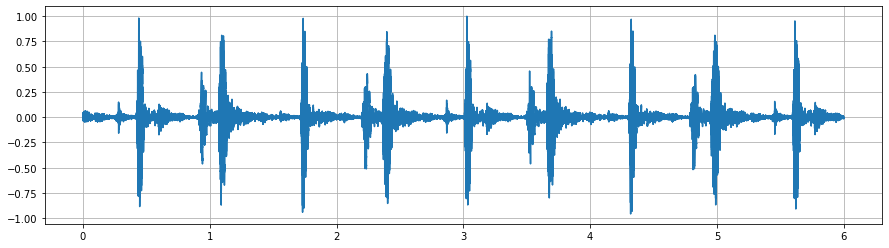

In [196]:
audio = normalize_audio(audio_data)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

In [197]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [198]:
hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (400, 2048)


In [199]:
print("First frame:")
audio_framed[1]

First frame:


array([ 0.01057793,  0.0095972 ,  0.01323993, ..., -0.02514886,
       -0.02619965, -0.02921191])

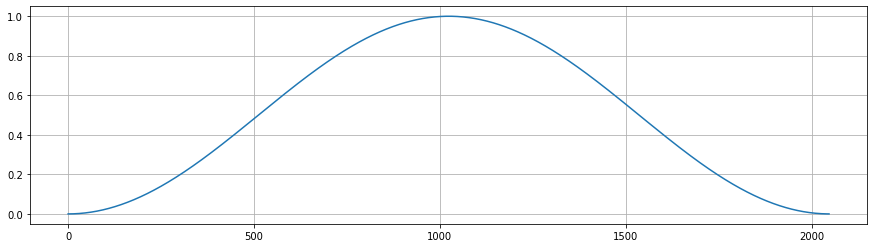

In [200]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

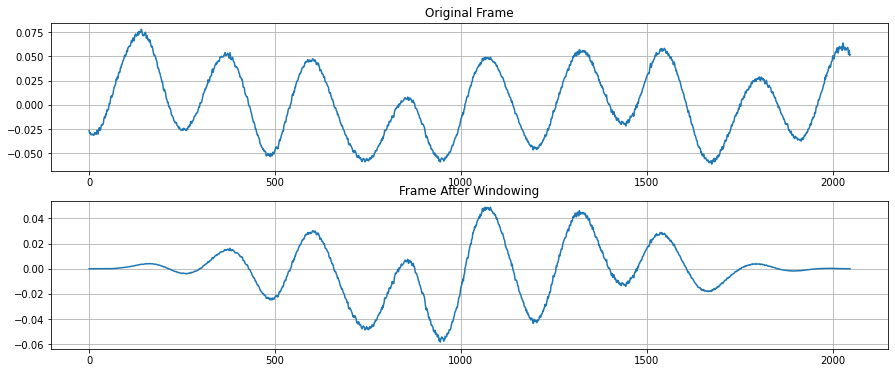

In [201]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [202]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [203]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [204]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(400, 1025)


In [205]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 22050.0


In [206]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [207]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [208]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

MEL min: 0.0
MEL max: 3923.337321740179


array([   0,   12,   28,   51,   82,  125,  184,  265,  376,  528,  737,
       1024])

In [209]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

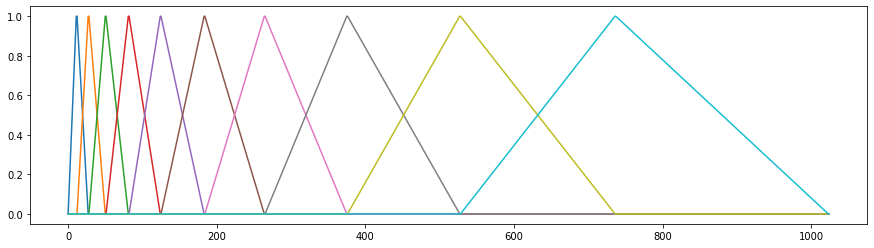

In [210]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [211]:
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

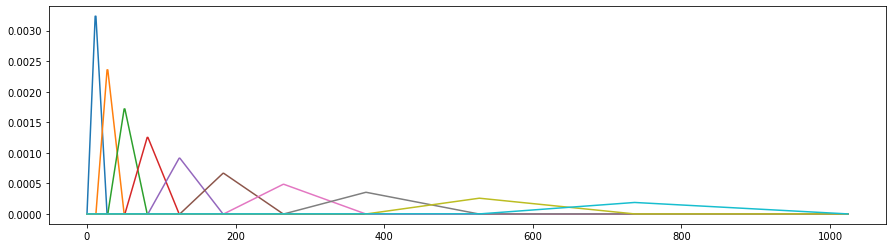

In [212]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [213]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 400)

In [214]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [215]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 400)

In [216]:
cepstral_coefficents[:, 0]

array([-8.83680390e+01,  1.55257896e+01,  8.94118727e+00,  2.12026367e+01,
        6.40881871e+00,  9.08784278e+00,  2.37478839e+00,  1.53032733e+00,
        5.56673673e-01,  1.47911178e+00,  1.35373950e-13, -1.47911178e+00,
       -5.56673673e-01, -1.53032733e+00, -2.37478839e+00, -9.08784278e+00,
       -6.40881871e+00, -2.12026367e+01, -8.94118727e+00, -1.55257896e+01,
        1.24971279e+02, -1.55257896e+01, -8.94118727e+00, -2.12026367e+01,
       -6.40881871e+00, -9.08784278e+00, -2.37478839e+00, -1.53032733e+00,
       -5.56673673e-01, -1.47911178e+00, -5.78749568e-14,  1.47911178e+00,
        5.56673673e-01,  1.53032733e+00,  2.37478839e+00,  9.08784278e+00,
        6.40881871e+00,  2.12026367e+01,  8.94118727e+00,  1.55257896e+01])

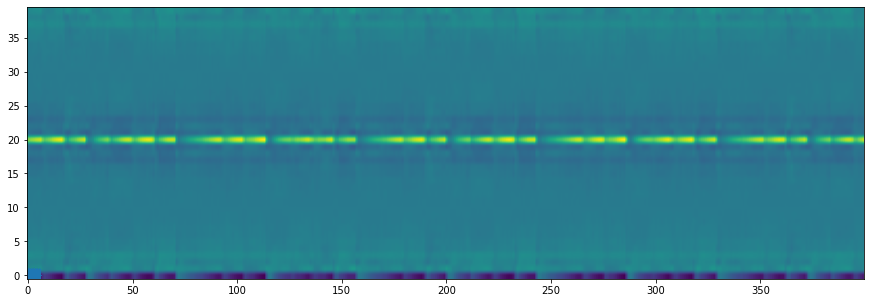

In [217]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower')

# mfcc implementation (haythamfayek)

In [218]:
with wave.open("data/raw/10 Africa.wav", "rb") as wav_file:
    frame_count = wav_file.getnframes()
    channel_count = wav_file.getnchannels()
    sample_rate = wav_file.getframerate()
    sample_width = wav_file.getsampwidth()

    clip_length = 4
    img_height = 0.5
    img_width = img_height*frame_count/(sample_rate*clip_length) # img_height*song_length/clip_length

    byte_data = wav_file.readframes(frame_count)
    audio_data = np.frombuffer(byte_data, dtype=np.int16).reshape((frame_count, channel_count)).T
    signal = audio_data[0,sample_rate:sample_rate*7]

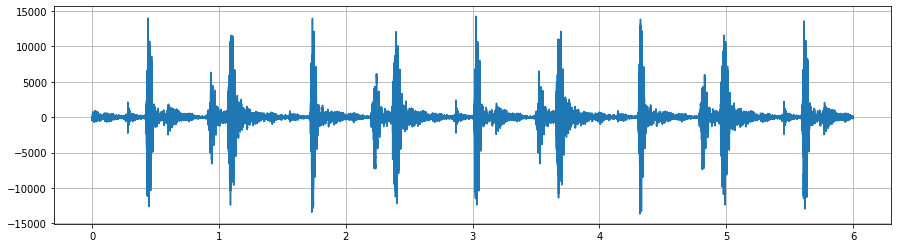

In [226]:
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(signal) / sample_rate, num=len(signal)), signal)
plt.grid(True)

In [219]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

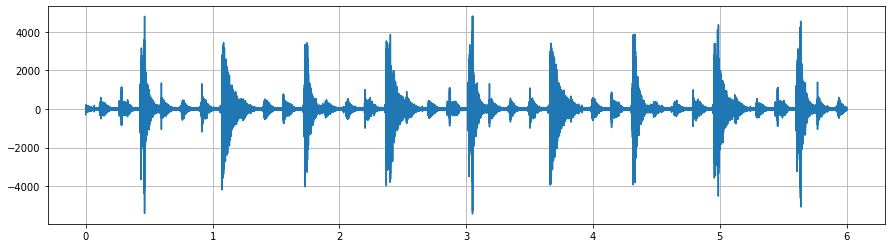

In [227]:
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(emphasized_signal) / sample_rate, num=len(emphasized_signal)), emphasized_signal)
plt.grid(True)

In [220]:
frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]


In [221]:
frames *= np.hamming(frame_length)

In [232]:
len(frames)

598

In [222]:
NFFT = 512

mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

In [223]:
nfilt = 40

low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

In [224]:
num_ceps = 12
mfcc = scipy.fftpack.dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13


In [225]:
len(mfcc[0])

12

# cnn import

In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

In [9]:
train_labels.shape

(50000, 1)

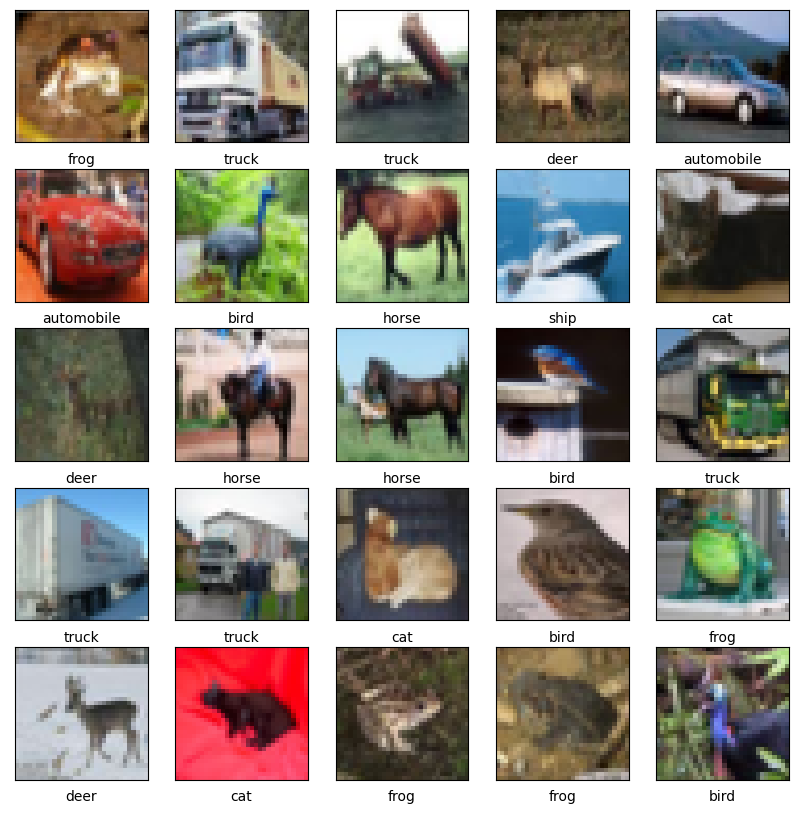

In [40]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-trai

In [22]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)             

In [24]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 34s 21ms/step - loss: 1.5264 - accuracy: 0.4379 - val_loss: 1.2702 - val_accuracy: 0.5445
Epoch 2/10
1563/1563 [==============================] - 43s 28ms/step - loss: 1.1700 - accuracy: 0.5844 - val_loss: 1.1399 - val_accuracy: 0.5848
Epoch 3/10
1563/1563 [==============================] - 41s 26ms/step - loss: 1.0154 - accuracy: 0.6406 - val_loss: 1.0103 - val_accuracy: 0.6426
Epoch 4/10
1563/1563 [==============================] - 40s 26ms/step - loss: 0.9159 - accuracy: 0.6779 - val_loss: 1.0463 - val_accuracy: 0.6418
Epoch 5/10
1563/1563 [==============================] - 41s 26ms/step - loss: 0.8463 - accuracy: 0.7021 - val_loss: 0.8963 - val_accuracy: 0.6875
Epoch 6/10
1563/1563 [==============================] - 43s 27ms/step - loss: 0.7858 - accuracy: 0.7238 - val_loss: 0.8880 - val_accuracy: 0.6937
Epoch 7/10
1563/1563 [==============================] - 46s 30ms/step - loss: 0.7354 - accuracy: 0.7423 - val_loss: 0.8486 -

313/313 - 1s - loss: 0.8587 - accuracy: 0.7113 - 1s/epoch - 4ms/step


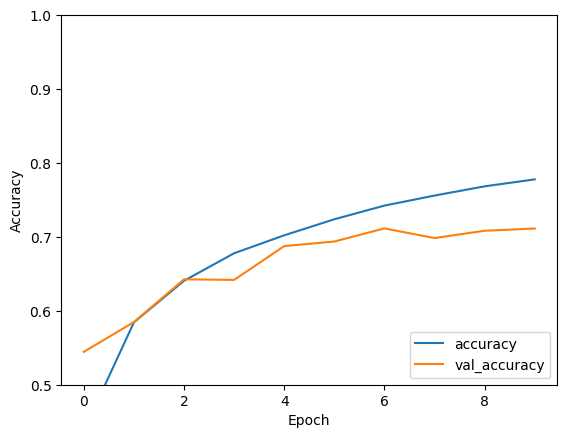

In [25]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [26]:
print(test_acc)

0.7113000154495239


In [6]:
import audio_metadata as meta
from tinytag import TinyTag

In [35]:
audio = TinyTag.get('data/raw/baroque/Canon in D.wav')

In [36]:
title = audio.title
artist = audio.artist
album = audio.album

# get uri

In [1]:
import spotipy as sp

In [2]:
client_id = '5e59bf996e30412d802b50c56c23fbc1'
client_secret = '7b221a486fcf4ea9a9246a3b1dfac445'

In [3]:
spotifyObject = sp.Spotify(auth_manager=sp.oauth2.SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

In [39]:
query = "remaster%20track:{0}%20artist:{1}%20album:{2}".format(title, artist, album)
(spotifyObject.search(query))['tracks']['items'][0]['uri'].split(':')[2]

'1c3GkbZBnyrQ1cm4TGHFrK'

# chromagram

In [24]:
wav_filepath = "data/raw/baroque/Canon in D.wav"

with wave.open(wav_filepath, "rb") as wav_file:
        frame_count = wav_file.getnframes()
        channel_count = wav_file.getnchannels()
        sample_rate = wav_file.getframerate()
        sample_width = wav_file.getsampwidth()

        clip_length = 4
        img_height = 5
        img_width = img_height*frame_count/(sample_rate*clip_length) # img_height*song_length/clip_length

        y, sr = librosa.load(wav_filepath, duration=frame_count/sample_rate)
        
        byte_data = wav_file.readframes(frame_count)
        audio_data = np.frombuffer(byte_data, dtype=np.int16).reshape((frame_count, channel_count)).T
        
chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
        

In [48]:
# Use an energy (magnitude) spectrum instead of power spectrogram

S = np.abs(librosa.stft(y))
chroma = librosa.feature.chroma_stft(S=S, sr=sr)

In [44]:
# Use a pre-computed power spectrogram with a larger frame

S = np.abs(librosa.stft(y, n_fft=4096))**2
chroma = librosa.feature.chroma_stft(S=S, sr=sr)

In [27]:
import librosa.display

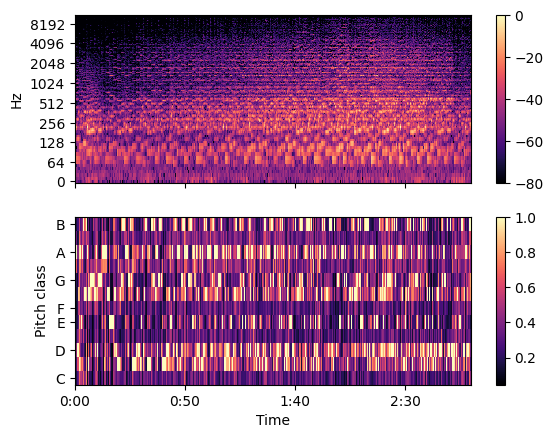

In [49]:
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                               y_axis='log', x_axis='time', ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].label_outer()
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])

# cnn mine

In [15]:
#load data

training_data = "C:/Users/anany\Cambridge\Part II Project\data/raw_copy/train"
testing_data = "C:/Users/anany\Cambridge\Part II Project\data/raw_copy/test"


In [16]:
generate_images(training_data, "data/images_train/images_initial", "spectrogram")
generate_images(testing_data, "data/images_train/images_initial", "spectrogram")


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/anany\\Cambridge\\Part II Project\\data/raw_copy/train'

In [ ]:
split_data("data\images_test\images_initial", "data\images_test\images_split")
split_data("data\images_test\images_initial", "data\images_test\images_split")

#training_images, training_labels = 
#testing_images, testing_labels = 

# spectrogram

In [2]:
import wave
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import io
from PIL import Image

In [3]:
wav_filepath = 'C:/Users/anany/Cambridge\Part II Project\data/raw/baroque\Canon in D major.wav'
image_folderpath = 'C:/Users/anany\Cambridge\Part II Project\data/test'

In [ ]:
# generate n random unique numbers
# assign, record, category

In [5]:
uid = 0 # get

with wave.open(wav_filepath, "rb") as wav_file:
    frame_count = wav_file.getnframes()
    channel_count = wav_file.getnchannels()
    sample_rate = wav_file.getframerate()
    sample_width = wav_file.getsampwidth()

    clip_length = 4
    img_height = 5
    img_width = img_height*frame_count/(sample_rate*clip_length) # img_height*song_length/clip_length

    byte_data = wav_file.readframes(frame_count)
    audio_data = np.frombuffer(byte_data, dtype=np.int16).reshape((frame_count, channel_count)).T
    
    print("hi")

name = os.path.basename(wav_filepath)[:-4]
genre = os.path.basename(os.path.split(wav_filepath)[0])

for i in range(2):
    frequencies, times, spectrogram = signal.stft(x=audio_data[i], fs=sample_rate)
    
    fig = plt.figure(frameon=False, figsize=(img_width, img_height), dpi=100)
    im = plt.pcolormesh(times, 
                        frequencies, 
                        abs(spectrogram), shading='auto')
    plt.axis('off')
    plt.close()

    canvas = FigureCanvas(fig)
    buf = io.BytesIO()
    canvas.print_png(buf)

    buf.seek(0)
    image = Image.open(buf)

    image = image.crop(image.getbbox())
    print(image.size)

    width, height = image.size

    temp = 0
    count = 0
    while ((count + 1) * height <= width):
        sample = image.crop((count * height, 0, (count + 1) * height, height))
        name = "{0}_ch{1}_{2}_{3}.png".format(uid, i, count, genre)
        sample.save(os.path.join(image_folderpath, name))
        temp+=height
        count += 1

    print(i)

    
     

hi
(17437, 385)
0
(17437, 385)
1


In [20]:
from data_processing import *

In [23]:
(j, k), (m, n) = load_data(image_folderpath, 0.75)

67

In [28]:
from cnn.reshape import Reshape
from cnn.dense import Dense
from cnn.activation import *
from cnn.convolutional import Convolutional

ModuleNotFoundError: No module named 'cnn.reshape'; 'cnn' is not a package

In [27]:
network = [
        Convolutional((1, 28, 28), 3, 5),
        Sigmoid(),
        Reshape((5, 26, 26), (5 * 26 * 26, 1)),
        Dense(5*26*26, 100),
        Sigmoid(),
        Dense(100, 2),
        Sigmoid()
    ]

NameError: name 'Convolutional' is not defined

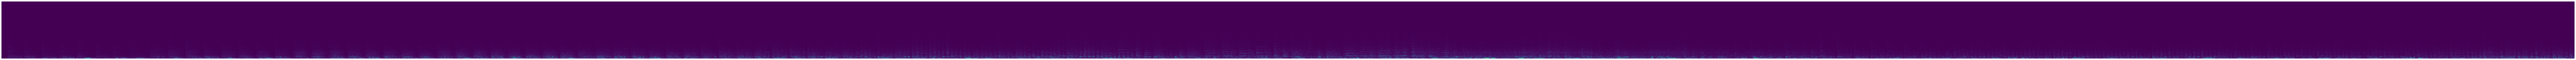

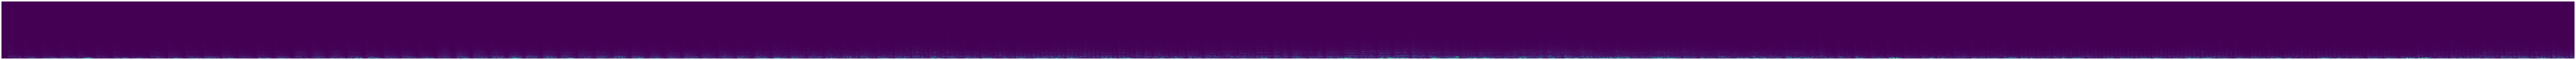

In [90]:

    
    
    '''psd_ch1 = 10*np.log10(abs(spectrogram)+1)
    fig_ch1 = plt.figure(frameon=False, figsize=(img_width, img_height), dpi=100)
    im_1 = plt.pcolormesh(times, frequencies, psd_ch1, shading='auto')
    plt.axis('off')
    plt.close()'''

In [ ]:
with wave.open(wav_filepath, "rb") as wav_file:
    frame_count = wav_file.getnframes()
    channel_count = wav_file.getnchannels()
    sample_rate = wav_file.getframerate()
    sample_width = wav_file.getsampwidth()

    clip_length = 4
    img_height = 5
    img_width = img_height*frame_count/(sample_rate*clip_length) # img_height*song_length/clip_length

    byte_data = wav_file.readframes(frame_count)
    audio_data = np.frombuffer(byte_data, dtype=np.int16).reshape((frame_count, channel_count)).T
    #audio_data_unpacked = np.array(struct.unpack("h" * wav_file.getnframes(), wav_data_1))
    #sample_rate, data_arr = wavfile.read(wav_filepath)

    #x = fft(audio_data[:,0])

name = os.path.basename(wav_filepath)[:-4]
genre = os.path.basename(os.path.split(wav_filepath)[0])
uri = get_uri(wav_filepath)

if (len(audio_data) == 1): # use channel count?
    frequencies, times, spectrogram = signal.stft(x=audio_data[0], fs=sample_rate)#, window=window, nperseg=nperseg, nfft=nfft)
    fig = plt.figure(frameon=False, dpi = None)
    im = plt.pcolormesh(times, frequencies, spectrogram, shading='auto')
    fig.colorbar(im)
    fig.savefig((data_folderpath + "/" + os.path.basename(wav_filepath).split('.')[0] + ".png"), bbox_inches = "tight", pad_inches = 0)

elif (len(audio_data) == 2):
    frequencies_ch1, times_ch1, spectrogram_ch1 = signal.stft(x=audio_data[0], fs=sample_rate)#, window=window, nperseg=nperseg, nfft=nfft, return_onesided=True)#, mode='complex')
    psd_ch1 = 10*np.log10(abs(spectrogram_ch1)+1)
    fig_ch1 = plt.figure(frameon=False, figsize=(img_width, img_height), dpi=100)
    im_1 = plt.pcolormesh(times_ch1, frequencies_ch1, psd_ch1, shading='auto')
    plt.axis('off')
    plt.close()
    #fig_ch1.colorbar(im_1)

    #plt.show()

    frequencies_ch2, times_ch2, spectrogram_ch2 = signal.stft(x=audio_data[1], fs=sample_rate)#, window=window, nperseg=nperseg, nfft=nfft)#, return_onesided=True), mode='magnitude')
    psd_ch2 = 10*np.log10(abs(spectrogram_ch2)+1)
    fig_ch2 = plt.figure(frameon=False, figsize=(img_width, img_height), dpi=100)
    im_2 = plt.pcolormesh(times_ch2, frequencies_ch2, psd_ch2, shading='auto')
    plt.axis('off')
    plt.close()
    #fig_ch2.colorbar(im_2)

    #plt.show()

    label = str(np.where(np.asarray(labels)==genre)[0])

    fig_ch1.savefig((data_folderpath + "/" + uri + "_" + "_ch1.png"), bbox_inches = "tight", pad_inches = 0, dpi = 100)
    fig_ch2.savefig((data_folderpath + "/" + uri + "_" + "_ch2.png"), bbox_inches = "tight", pad_inches = 0, dpi = 100)

else:
    raise ValueError('Invalid number of channels')
